## Step 1: Install Dependencies and Import Libraries

In [1]:
# Install required packages
%pip install librosa soundfile audioread scikit-learn numpy pandas matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import librosa
import librosa.display
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")
print(f"Librosa version: {librosa.__version__}")

✅ All libraries imported successfully
Librosa version: 0.11.0


## Step 2: Load Raw Audio Data

Load audio samples from the `data/raw/audio/` directory organized by member (speaker).

In [3]:
# Define paths
AUDIO_DIR = Path('../data/raw/audio')
OUTPUT_DIR = Path('../data/processed')
MODEL_DIR = Path('../notebook')

# Create output directories if they don't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print(f"Audio directory: {AUDIO_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")

Audio directory: ../data/raw/audio
Output directory: ../data/processed
Model directory: ../notebook


In [4]:
# Scan audio directory and load file paths
def load_audio_paths(audio_dir):
    """
    Load all audio file paths organized by speaker (member)
    Returns: List of tuples (file_path, speaker_label)
    """
    audio_files = []
    
    for member_folder in audio_dir.iterdir():
        if member_folder.is_dir():
            member_name = member_folder.name
            print(f"\nFound speaker: {member_name}")
            
            for audio_file in member_folder.iterdir():
                if audio_file.suffix.lower() in ['.wav', '.opus', '.mp3', '.flac']:
                    audio_files.append((str(audio_file), member_name))
                    print(f"  - {audio_file.name}")
    
    return audio_files

# Load all audio files
audio_files = load_audio_paths(AUDIO_DIR)
print(f"\n✅ Total audio files loaded: {len(audio_files)}")
print(f"Unique speakers: {len(set([label for _, label in audio_files]))}")


Found speaker: member 3
  - Confirm_transaction.opus
  - Yes_approve.opus

Found speaker: member 4
  - Confirm_transaction.opus
  - Yes_approve.opus

Found speaker: member 2
  - Confirm_transaction.opus
  - Yes_approve.opus

Found speaker: member 1
  - Confirm_transaction.opus
  - Yes_approve.opus

✅ Total audio files loaded: 8
Unique speakers: 4


## Step 3: Audio Augmentation Functions

Increase dataset diversity by applying transformations to the original audio.

In [5]:
def augment_audio(audio, sr):
    """
    Apply audio augmentation techniques
    Returns list of augmented audio samples
    """
    augmented_samples = [audio]  # Include original
    
    # 1. Pitch shift (up and down)
    try:
        pitch_up = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
        pitch_down = librosa.effects.pitch_shift(audio, sr=sr, n_steps=-2)
        augmented_samples.extend([pitch_up, pitch_down])
    except Exception as e:
        print(f"  Warning: Pitch shift failed - {e}")
    
    # 2. Time stretch (faster and slower)
    try:
        time_fast = librosa.effects.time_stretch(audio, rate=1.1)
        time_slow = librosa.effects.time_stretch(audio, rate=0.9)
        augmented_samples.extend([time_fast, time_slow])
    except Exception as e:
        print(f"  Warning: Time stretch failed - {e}")
    
    # 3. Add background noise
    try:
        noise = np.random.randn(len(audio))
        noisy = audio + 0.005 * noise
        augmented_samples.append(noisy)
    except Exception as e:
        print(f"  Warning: Noise addition failed - {e}")
    
    return augmented_samples

print("✅ Augmentation functions defined")

✅ Augmentation functions defined


## Step 4: Feature Extraction

Extract MFCC (Mel-frequency cepstral coefficients) and other audio features.

In [6]:
def extract_features(audio, sr, n_mfcc=13):
    """
    Extract audio features for voice verification
    
    Features:
    - MFCC (13 coefficients)
    - Spectral rolloff
    - Zero crossing rate
    - Spectral centroid
    - RMS energy
    
    Returns: 1D feature vector
    """
    features = []
    
    # 1. MFCCs (mean across time)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    features.extend(mfccs_mean)
    
    # 2. Spectral rolloff (mean)
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    features.append(np.mean(rolloff))
    
    # 3. Zero crossing rate (mean)
    zcr = librosa.feature.zero_crossing_rate(audio)
    features.append(np.mean(zcr))
    
    # 4. Spectral centroid (mean)
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    features.append(np.mean(centroid))
    
    # 5. RMS energy (mean)
    rms = librosa.feature.rms(y=audio)
    features.append(np.mean(rms))
    
    return np.array(features)

print("✅ Feature extraction function defined")
print(f"Total features per sample: {13 + 4} (13 MFCCs + 4 other features)")

✅ Feature extraction function defined
Total features per sample: 17 (13 MFCCs + 4 other features)


## Step 5: Process All Audio Files

Load, augment, and extract features from all audio samples.

In [7]:
def process_audio_dataset(audio_files, apply_augmentation=True):
    """
    Process entire audio dataset
    Returns: features array and labels array
    """
    all_features = []
    all_labels = []
    
    print("Processing audio files...\n")
    
    for i, (audio_path, label) in enumerate(audio_files, 1):
        print(f"[{i}/{len(audio_files)}] Processing: {Path(audio_path).name} ({label})")
        
        try:
            # Load audio
            audio, sr = librosa.load(audio_path, sr=16000)  # Standardize to 16kHz
            
            # Apply augmentation
            if apply_augmentation:
                augmented_samples = augment_audio(audio, sr)
                print(f"  Generated {len(augmented_samples)} augmented samples")
            else:
                augmented_samples = [audio]
            
            # Extract features from each augmented sample
            for aug_audio in augmented_samples:
                features = extract_features(aug_audio, sr)
                all_features.append(features)
                all_labels.append(label)
            
        except Exception as e:
            print(f"  ❌ Error processing {audio_path}: {e}")
            continue
    
    X = np.array(all_features)
    y = np.array(all_labels)
    
    print(f"\n✅ Processing complete!")
    print(f"Total samples: {len(X)}")
    print(f"Feature dimensions: {X.shape}")
    print(f"Unique labels: {np.unique(y)}")
    
    return X, y

# Process all audio files
X, y = process_audio_dataset(audio_files, apply_augmentation=True)

Processing audio files...

[1/8] Processing: Confirm_transaction.opus (member 3)
  Generated 6 augmented samples
  Generated 6 augmented samples
[2/8] Processing: Yes_approve.opus (member 3)
  Generated 6 augmented samples
[2/8] Processing: Yes_approve.opus (member 3)
  Generated 6 augmented samples
[3/8] Processing: Confirm_transaction.opus (member 4)
[3/8] Processing: Confirm_transaction.opus (member 4)
  Generated 6 augmented samples
  Generated 6 augmented samples
[4/8] Processing: Yes_approve.opus (member 4)
[4/8] Processing: Yes_approve.opus (member 4)
  Generated 6 augmented samples
[5/8] Processing: Confirm_transaction.opus (member 2)
  Generated 6 augmented samples
[5/8] Processing: Confirm_transaction.opus (member 2)
  Generated 6 augmented samples
  Generated 6 augmented samples
[6/8] Processing: Yes_approve.opus (member 2)
[6/8] Processing: Yes_approve.opus (member 2)
  Generated 6 augmented samples
  Generated 6 augmented samples
[7/8] Processing: Confirm_transaction.opus 

## Step 6: Prepare Data for Training

Encode labels, scale features, and split into train/test sets.

In [9]:
# Save features to CSV file
feature_columns = ([f'mfcc_{i+1}' for i in range(13)] + 
                   ['spectral_rolloff', 'zero_crossing_rate', 'spectral_centroid', 'rms_energy'])

# Create DataFrame
features_df = pd.DataFrame(X, columns=feature_columns)
features_df['speaker_label'] = y

# Save to CSV
features_csv_path = OUTPUT_DIR / 'audio_features.csv'
features_df.to_csv(features_csv_path, index=False)

print(f"✅ Audio features saved to: {features_csv_path}")
print(f"   Shape: {features_df.shape}")
print(f"\nFirst few rows:")
print(features_df.head())

# Also save a summary statistics file
summary_stats = features_df.groupby('speaker_label').describe()
summary_path = OUTPUT_DIR / 'audio_features_summary.csv'
summary_stats.to_csv(summary_path)
print(f"\n✅ Summary statistics saved to: {summary_path}")

✅ Audio features saved to: ../data/processed/audio_features.csv
   Shape: (48, 18)

First few rows:
       mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0 -386.702515  72.214661  10.307150  12.654577  -1.373655   8.700493   
1 -407.562531  70.025253   7.211646   7.649713  -0.922087   8.974845   
2 -414.034271  83.704567   2.081777  21.860374 -12.805246  15.901686   
3 -402.222046  72.065559  11.441350   8.296681  -3.324367   7.948971   
4 -408.579773  70.091209   9.909713   9.254278  -1.658919   7.913339   

      mfcc_7     mfcc_8     mfcc_9    mfcc_10   mfcc_11    mfcc_12    mfcc_13  \
0  -1.585858  10.503376  -1.799579  -9.949799 -1.105087 -10.044647  -1.216380   
1  -1.977805   9.914675 -14.565203  -4.006063 -7.403659  -5.432493  -5.375602   
2 -11.046853  14.092195   0.665950  -1.695288 -8.316955  -0.780400 -12.408356   
3  -1.351622  10.249553  -2.603998 -10.070680 -2.230382 -11.166694  -2.062541   
4  -2.724261   8.898081  -2.994004 -10.244109 -2.676605 -11.26

In [8]:
# Encode labels (member 1, member 2, etc. -> 0, 1, 2, ...)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label} -> {i}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Features scaled")
print(f"Feature mean: {X_scaled.mean():.4f}")
print(f"Feature std: {X_scaled.std():.4f}")

Label encoding:
  member 1 -> 0
  member 2 -> 1
  member 3 -> 2
  member 4 -> 3

✅ Features scaled
Feature mean: -0.0000
Feature std: 1.0000


In [10]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print("Dataset split:")
print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y_train == i)
    print(f"  {label}: {count} samples")

Dataset split:
  Training samples: 38
  Testing samples: 10

Class distribution in training set:
  member 1: 9 samples
  member 2: 10 samples
  member 3: 9 samples
  member 4: 10 samples


## Step 7: Train Voice Verification Model

Train a Random Forest classifier for speaker identification.

In [11]:
# Train Random Forest classifier
print("Training Random Forest classifier...\n")

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)

print("\n✅ Model training complete!")

Training Random Forest classifier...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s



✅ Model training complete!


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished


## Step 8: Evaluate Model Performance

In [12]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Testing Accuracy:  {test_accuracy:.2%}")
print("="*60)

MODEL PERFORMANCE
Training Accuracy: 100.00%
Testing Accuracy:  80.00%


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


In [13]:
# Detailed classification report
print("\nClassification Report (Test Set):")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Classification Report (Test Set):
              precision    recall  f1-score   support

    member 1       1.00      1.00      1.00         3
    member 2       0.50      1.00      0.67         2
    member 3       1.00      0.33      0.50         3
    member 4       1.00      1.00      1.00         2

    accuracy                           0.80        10
   macro avg       0.88      0.83      0.79        10
weighted avg       0.90      0.80      0.78        10



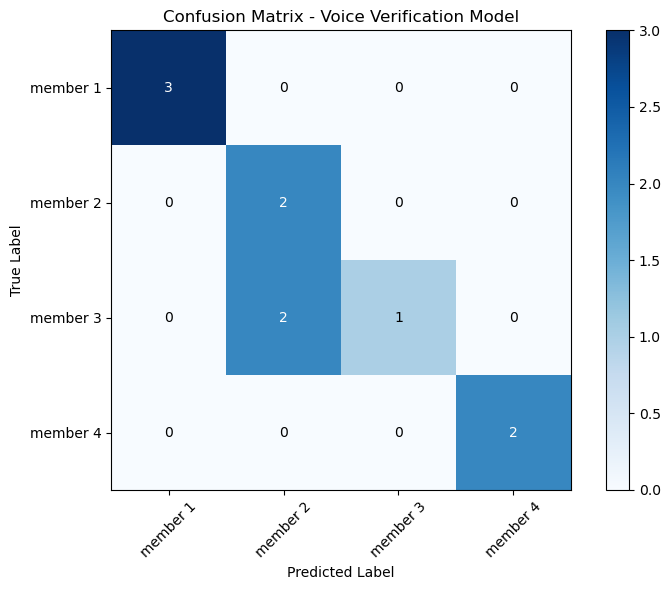

In [14]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Voice Verification Model')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

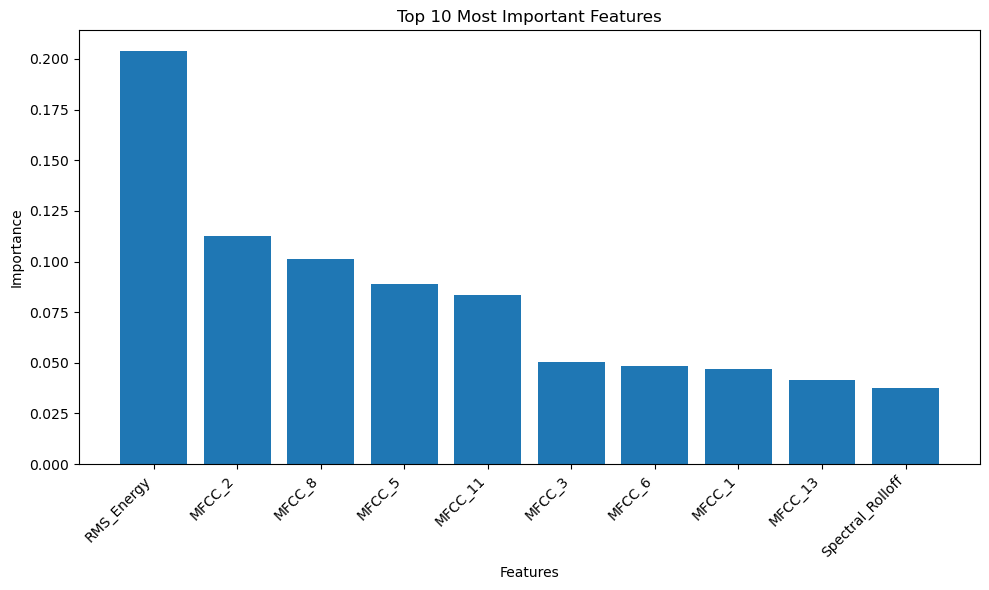


Top 10 Features:
1. RMS_Energy: 0.2039
2. MFCC_2: 0.1127
3. MFCC_8: 0.1014
4. MFCC_5: 0.0887
5. MFCC_11: 0.0834
6. MFCC_3: 0.0506
7. MFCC_6: 0.0485
8. MFCC_1: 0.0471
9. MFCC_13: 0.0416
10. Spectral_Rolloff: 0.0374


In [15]:
# Feature importance
feature_names = ([f'MFCC_{i+1}' for i in range(13)] + 
                ['Spectral_Rolloff', 'Zero_Crossing_Rate', 'Spectral_Centroid', 'RMS_Energy'])

importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:10]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.title('Top 10 Most Important Features')
plt.bar(range(10), importances[indices])
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
for i, idx in enumerate(indices, 1):
    print(f"{i}. {feature_names[idx]}: {importances[idx]:.4f}")

## Step 9: Save Model and Preprocessors

In [17]:
# Save model
model_path = MODEL_DIR / 'voice_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"✅ Model saved to: {model_path}")

# Save scaler
scaler_path = MODEL_DIR / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler saved to: {scaler_path}")

# Save label encoder
encoder_path = MODEL_DIR / 'label_encoder.pkl'
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"✅ Label encoder saved to: {encoder_path}")

print("\n" + "="*60)
print("🎉 TRAINING COMPLETE!")
print("="*60)
print(f"Model accuracy: {test_accuracy:.2%}")
print(f"Number of speakers: {len(label_encoder.classes_)}")
print(f"Total training samples: {len(X_train)}")
print("="*60)

✅ Model saved to: ../notebook/voice_model.pkl
✅ Scaler saved to: ../notebook/scaler.pkl
✅ Label encoder saved to: ../notebook/label_encoder.pkl

🎉 TRAINING COMPLETE!
Model accuracy: 80.00%
Number of speakers: 4
Total training samples: 38


## Step 10: Test Voice Verification

Load the saved model and test it on a new audio sample.

In [18]:
def verify_voice(audio_path, model, scaler, label_encoder, threshold=0.7):
    """
    Verify speaker identity from audio file
    
    Args:
        audio_path: Path to audio file
        model: Trained classifier
        scaler: Feature scaler
        label_encoder: Label encoder
        threshold: Confidence threshold for verification
    
    Returns:
        dict with verification results
    """
    # Load and extract features
    audio, sr = librosa.load(audio_path, sr=16000)
    features = extract_features(audio, sr)
    features_scaled = scaler.transform([features])
    
    # Predict
    prediction = model.predict(features_scaled)[0]
    probabilities = model.predict_proba(features_scaled)[0]
    confidence = probabilities[prediction]
    
    # Get speaker name
    speaker = label_encoder.inverse_transform([prediction])[0]
    
    # Verification result
    is_verified = confidence >= threshold
    
    return {
        'speaker': speaker,
        'confidence': confidence,
        'is_verified': is_verified,
        'all_probabilities': dict(zip(label_encoder.classes_, probabilities))
    }

print("✅ Verification function defined")

✅ Verification function defined


In [19]:
# Test on a sample from the dataset
test_audio_path = audio_files[0][0]  # First audio file
expected_speaker = audio_files[0][1]

print(f"Testing on: {Path(test_audio_path).name}")
print(f"Expected speaker: {expected_speaker}\n")

result = verify_voice(test_audio_path, model, scaler, label_encoder)

print("="*60)
print("VERIFICATION RESULT")
print("="*60)
print(f"Identified Speaker: {result['speaker']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Verification: {'✅ VERIFIED' if result['is_verified'] else '❌ REJECTED'}")
print(f"\nProbabilities for all speakers:")
for speaker, prob in result['all_probabilities'].items():
    print(f"  {speaker}: {prob:.2%}")
print("="*60)

Testing on: Confirm_transaction.opus
Expected speaker: member 3

VERIFICATION RESULT
Identified Speaker: member 3
Confidence: 80.52%
Verification: ✅ VERIFIED

Probabilities for all speakers:
  member 1: 1.20%
  member 2: 15.19%
  member 3: 80.52%
  member 4: 3.09%


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
